# Breakdown by borough

It seems doing groupbys in pandas is much quicker than on the DB, which is wierd. So we are gonna query all the raw data then do groupbys using pandas.

If you are querying more than a month of data you might want to split up your queries into several batches then concat the dataframes together.

In [1]:
import pandas as pd
import os
from datetime import datetime
import math

# plotly viz - use matplotlib if you prefer
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# cleanair modules
from cleanair.scoot import ScootQuery

In [2]:
secretfile = "../../terraform/.secrets/db_secrets.json"

# choose a start and end date for this query
start_datetime="2020-03-18 00:00:00"
end_datetime="2020-03-25 12:00:00"

# columns to analyse
columns = ["n_vehicles_in_interval", "occupancy_percentage", "congestion_percentage", "saturation"]

SQ = ScootQuery(secretfile=secretfile)

2020-03-27 09:16:24     INFO: Database connection information loaded from <_io.TextIOWrapper name='../../terraform/.secrets/db_secrets.json' mode='r' encoding='UTF-8'>


## Detector - borough join

This is a geo-spatial query run using PostGIS. We are going to find the borough that each sensor lies in and return a dataframe of joined detector-borough info.

In [3]:
join_df = SQ.detector_borough_join_df()

## Detector readings

Very simply, get all readings for all detectors in the given time period.

In [4]:
all_df = SQ.get_all_readings(start_datetime=start_datetime, end_datetime=end_datetime)

## Merge detector readings

Now that we have the readings from the detectors, we are going to merge the readings with the info about the detectors. This means we will have the borough that each detector (and thus each reading) is inside.

We are then going the groupby the borough and the timestamp. Thus for each borough and each timestamp we will have a group of detector readings.

In [5]:
readings_df = all_df.merge(join_df, on="detector_id")
readings_df = readings_df.sort_values("measurement_start_utc")
keys = ["name", "measurement_start_utc", "measurement_end_utc"]
gb = readings_df.groupby(keys)   # groupby borough and datetime

In [6]:
groups = list(gb.groups.keys())
print(type(groups))
df = pd.DataFrame.from_records(groups, columns=keys)

<class 'list'>


## Aggregation

Now we are going to calculate our aggregated statistics - mean and median (and sum for n vehicles).

In [7]:
for c in columns:
    median = gb[c].median()
    median.name = "med_" + c
    df = df.merge(median, on=keys)
    
    mean = gb[c].mean()
    mean.name = "avg_" + c
    df = df.merge(mean, on=keys)

total = gb["n_vehicles_in_interval"].sum()  # total for n vehicles
total.name = "sum_n_vehicles_in_interval"
df = df.merge(total, on=keys)


In [8]:
df.sample(10)

,name,measurement_start_utc,measurement_end_utc,med_n_vehicles_in_interval,avg_n_vehicles_in_interval,med_occupancy_percentage,avg_occupancy_percentage,med_congestion_percentage,avg_congestion_percentage,med_saturation,avg_saturation,sum_n_vehicles_in_interval
5419,Waltham Forest,2020-03-18 19:00:00,2020-03-18 20:00:00,363.0,387.094595,11.224810,13.687398,0.818966,4.511388,46.422414,47.308935,85935
5898,Westminster,2020-03-23 18:00:00,2020-03-23 19:00:00,189.0,243.888274,5.342277,7.775407,0.000000,1.154326,22.175439,25.862041,220475
721,Bromley,2020-03-18 01:00:00,2020-03-18 02:00:00,27.0,27.340659,0.493552,0.793634,0.000000,-0.194689,2.216667,3.587729,2488
4554,Redbridge,2020-03-20 06:00:00,2020-03-20 07:00:00,211.0,289.570201,4.762931,9.405212,0.000000,1.280366,20.706897,29.046285,101060
5320,Tower Hamlets,2020-03-22 04:00:00,2020-03-22 05:00:00,37.0,57.455577,0.796784,1.917255,0.000000,0.287285,2.947368,5.192735,30394
757,Bromley,2020-03-19 13:00:00,2020-03-19 14:00:00,446.0,438.516484,11.970935,15.025448,0.183333,1.892617,50.683333,57.337328,39905
2895,Hillingdon,2020-03-18 15:00:00,2020-03-18 16:00:00,402.0,453.677419,9.416528,12.899790,0.000000,1.941909,40.954762,43.893276,112512
5330,Tower Hamlets,2020-03-22 14:00:00,2020-03-22 15:00:00,282.0,304.966418,6.263942,8.993751,0.000000,1.161987,26.672414,29.092472,163462
4875,Southwark,2020-03-18 15:00:00,2020-03-18 16:00:00,358.0,382.240566,11.059408,15.951500,0.143966,4.422920,47.593391,51.914767,162070
2146,Hackney,2020-03-24 22:00:00,2020-03-24 23:00:00,91.0,126.698980,2.448606,4.793959,0.000000,0.968331,12.025000,14.456794,49666


## Show grid of borough aggregates

Now that we have aggregated stats for each borough, lets show the timeseries for each borough in a big grid. You can adjust the number of columns and rows to suit yourself. You may also wish to change the `width` and `height` of the fig.

Changing the `col` will display a different aggregated stat.

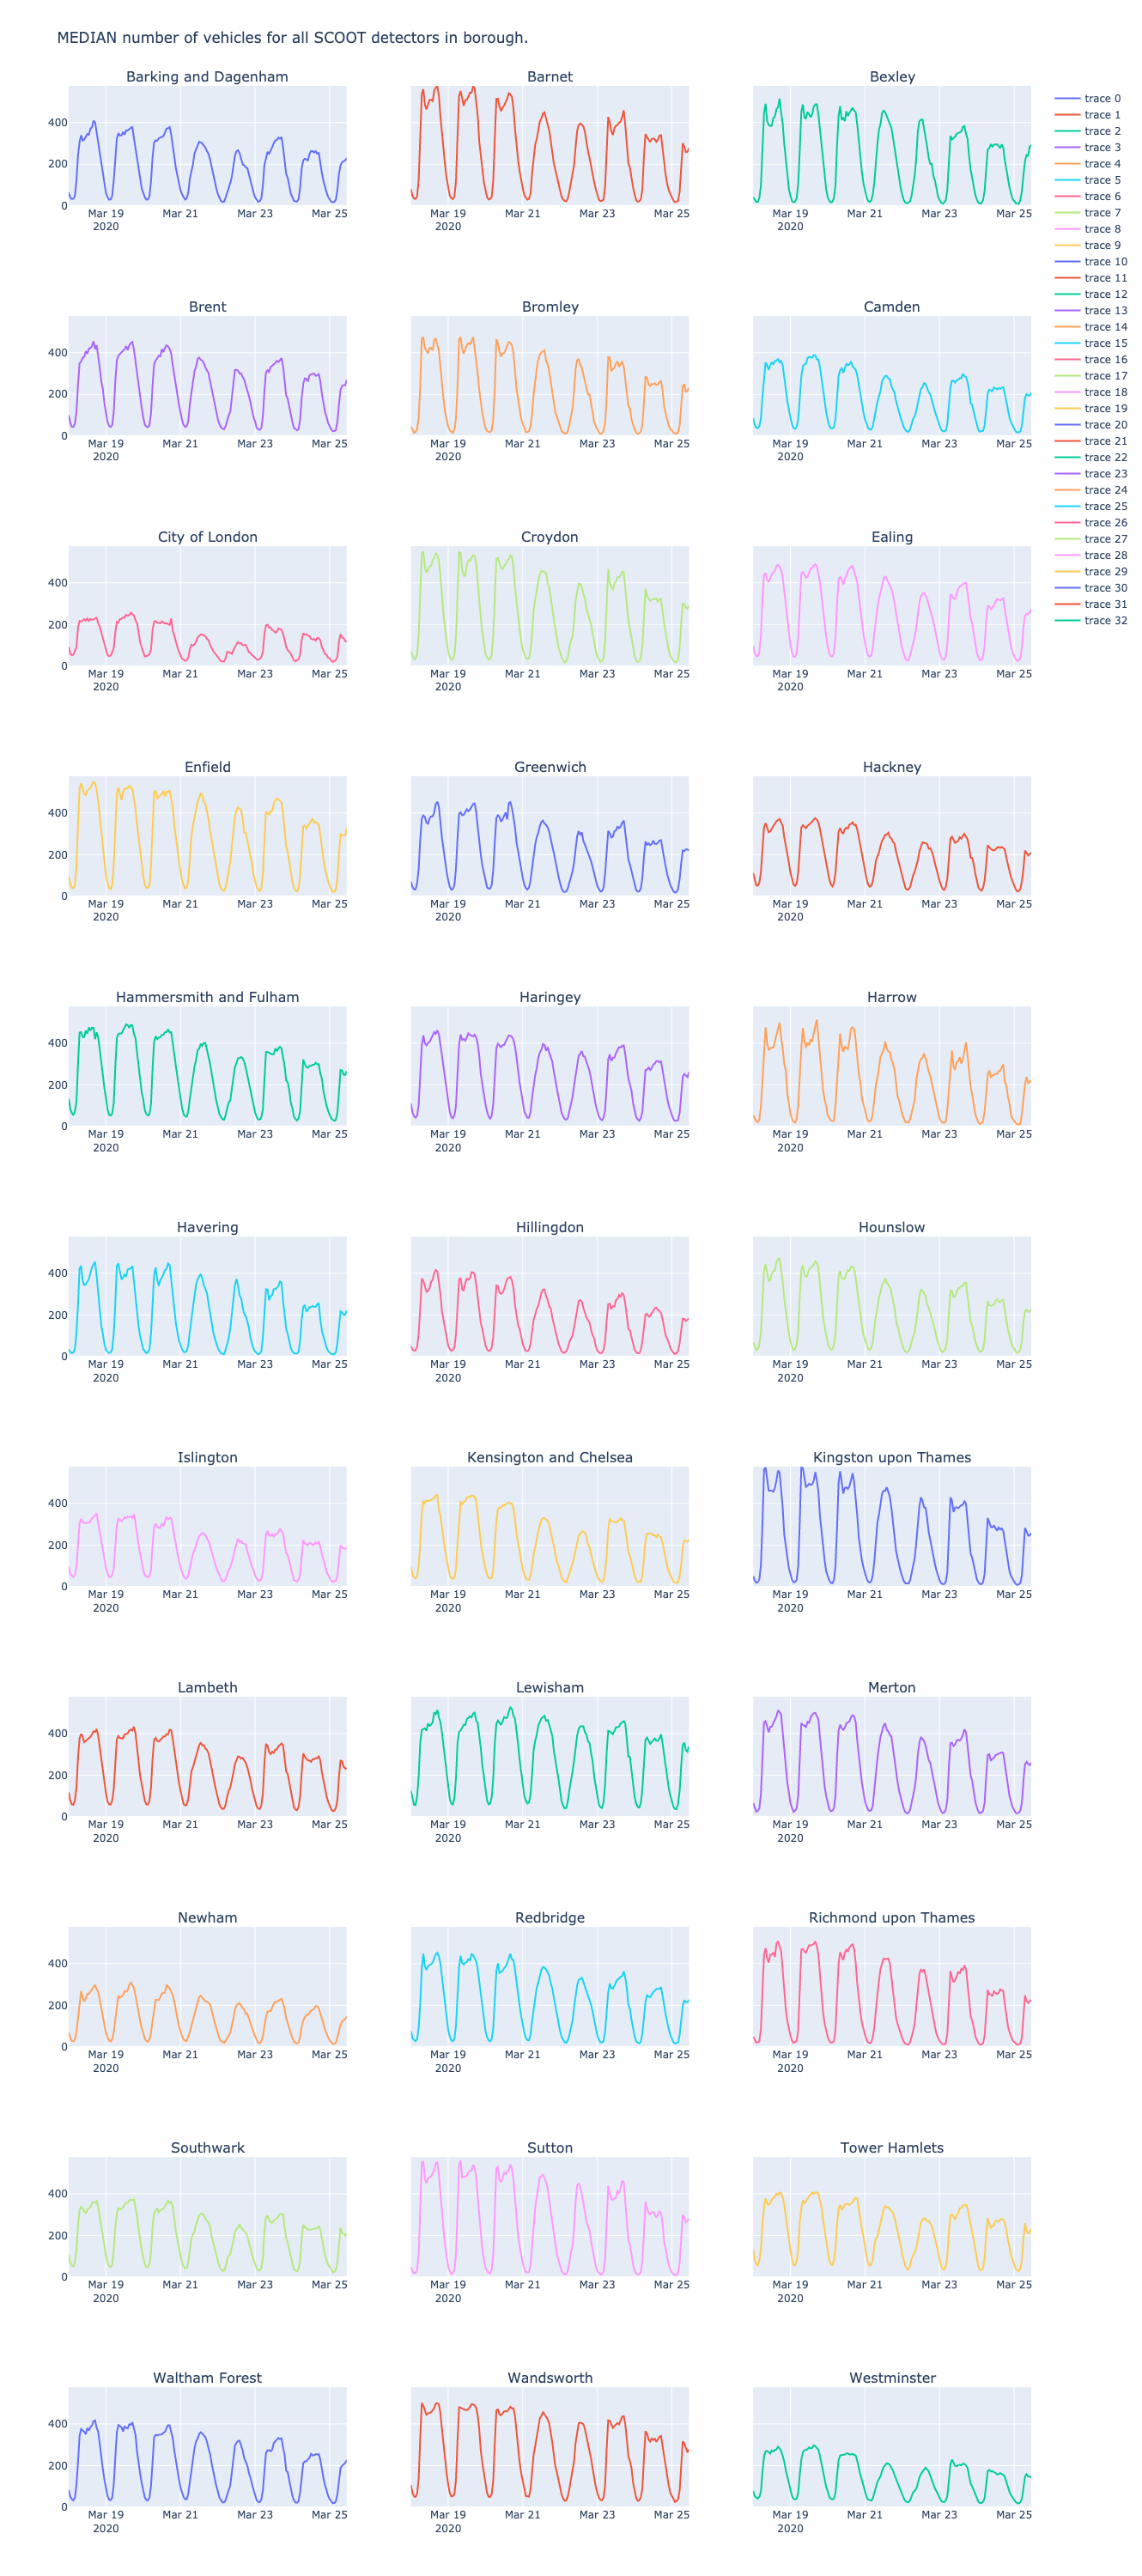

In [12]:
# get a list of all unique borough names
borough_names = list(df.name.unique())
borough_names.sort()

# choose what to show on figure
col = "med_n_vehicles_in_interval"
num_cols = 3
num_rows = math.ceil(len(borough_names) / num_cols)


fig = make_subplots(
    rows=num_rows, cols=num_cols, subplot_titles=borough_names, shared_xaxes=False, shared_yaxes=True
)

for i in range(num_rows):
    for j in range(num_cols):
        b_index = i * num_cols + j  # index of borough in name list
        if b_index == len(borough_names):
            break
        b_name = borough_names[b_index] # name of borough
        b_df = df.loc[df.name == b_name] # aggregated timeseries for borough
        fig.add_trace(go.Scatter(
            x=b_df["measurement_start_utc"], y=b_df[col]
        ), row=i+1, col=j+1)

nice_title = dict(
    sum_n_vehicles_in_interval="TOTAL number of vehicles for all SCOOT detectors in borough.",
    avg_n_vehicles_in_interval="AVERAGE number of vehicles for all SCOOT detectors in borough.",
    med_n_vehicles_in_interval="MEDIAN number of vehicles for all SCOOT detectors in borough."
)
y_max = df[col].max()
width=1200
height=3000
fig.update_yaxes(range=[0, y_max])   # fix the y axis range (may need to change manually)
fig.update_layout(
    width=width,
    height=height,
    title=nice_title[col],
)
fig.show()